In [1]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Activation, Input, Embedding, Reshape, MaxPooling1D, Conv1D
from keras.layers import LSTM, GRU, Conv1D
from keras.layers import Dropout, BatchNormalization, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.activations import sigmoid
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.callbacks import TensorBoard
import numpy as np
import random
import sys
import os

Using TensorFlow backend.


In [2]:
from libs.utils import text_preprocess

In [3]:
with open('data/dostoewskij.txt', encoding='utf-8') as f:
    dostoewskij_text = f.read().lower()
with open('data/non_dostoewskij_texts.txt', encoding='utf-8') as f:
    non_dostoewskij_text = f.read().lower()

dostoewskij_text = text_preprocess(dostoewskij_text)
non_dostoewskij_text = text_preprocess(non_dostoewskij_text)

# dostoewskij_text = clear_text_from_rare_chars(dostoewskij_text, delete_enters=True)
# non_dostoewskij_text = clear_text_from_rare_chars(non_dostoewskij_text, delete_enters=True)

print('dostoewskij_length:\t', len(dostoewskij_text))
print('non_dostoewskij_length:\t', len(non_dostoewskij_text))

dostoewskij_length:	 4911415
non_dostoewskij_length:	 173623913


In [4]:
from libs.utils import load_transformer

transformer = load_transformer('models/shm_c1')

chars = transformer.tokens
char_cats = len(chars)
print('total chars:', char_cats)

total chars: 42


In [5]:
print_len = 2000
pos = np.random.randint(len(dostoewskij_text))
print(dostoewskij_text[pos:pos+print_len])
print('-' * 100)
pos = np.random.randint(len(non_dostoewskij_text))
print(non_dostoewskij_text[pos:pos+print_len])

 

"золотым промыслом" и пользуясь неопытностью и пороками эксплуатируемого 

племени. представьте же себе, когда я прочел это, мне тотчас же вспомнилось, что 

мне еще пять лет тому приходило это самое на ум, именно то, что вот ведь негры 

от рабовладельцев теперь освобождены, а ведь им не уцелеть, потому что на эту 

свежую жертвочку как раз набросятся евреи, которых столь много на свете. подумал 

я это, и, уверяю вас, несколько раз потом в этот срок мне вспадало на мысль: "да 

что же там ничего об евреях не слышно, что в газетах не пишут, ведь эти негры 

евреям клад, неужели пропустят?" и вот дождался, написали в газетах, прочел. а 

дней десять тому назад прочел в "новом времени"   корреспонденцию из 

ковно, прехарактернейшую: "дескать, до того набросились там евреи на местное 

литовское население, что чуть не сгубили всех водкой, и только ксендзы спасли 

бедных опившихся, угрожая им муками ада и устраивая между ними общества 

трезвости". просвещенный корреспондент, правда,

In [6]:
n_batches = len(dostoewskij_text) // 30
batch_size = 16
#n_batches -= n_batches % batch_size
max_len = 200

In [7]:
# transform text into sequence of indices
dostoewskij_indexes        = transformer.transform(dostoewskij_text)
non_dostoewskij_indexes = transformer.transform(non_dostoewskij_text)

In [8]:
def split_data_into_correct_batches(text1_indexes, text2_indexes, make_equal_folding = True):
    prime_number = 2147483647
    
    X = np.zeros((n_batches, max_len), dtype=np.int64)
    Y = np.zeros((n_batches,), dtype=np.int64)
    
    choose_from_first = True
    index1 = 0
    index2 = 0
    for i in range(n_batches):
        if make_equal_folding:
            if choose_from_first:
                index1 = (index1 + prime_number) % (len(text1_indexes) - max_len + 1)
                X[i, :] = text1_indexes[index1:index1+max_len]
                Y[i] = 0
            else:
                index2 = (index2 + prime_number) % (len(text2_indexes) - max_len + 1)
                X[i, :] = text2_indexes[index2:index2+max_len]
                Y[i] = 1
                
            choose_from_first = not choose_from_first
        else:
            index1 = (index1 + prime_number) % (len(text1_indexes) + len(text2_indexes) - 2*max_len + 2)
            if index1 < len(text1_indexes) - max_len + 1:
                X[i, :] = text1_indexes[index1:index1 + max_len]
                Y[i] = 0
            else:
                index2 = index1 - (len(text1_indexes) - max_len + 1)
                X[i, :] = text2_indexes[index2:index2 + max_len]
                Y[i] = 1
    return X, Y

X, y = split_data_into_correct_batches(dostoewskij_indexes, non_dostoewskij_indexes, make_equal_folding=True)

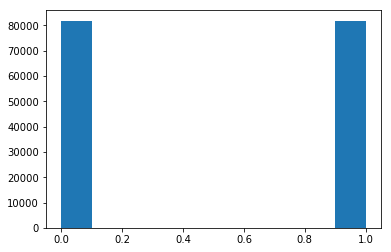

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

a = plt.hist(y)

In [10]:
from keras.losses import sparse_categorical_crossentropy

In [11]:
def create_char_rnn():
    inp = Input(shape=(max_len,), dtype="int32")
    v = Embedding(char_cats+1, int(char_cats / 1.5))(inp)
    h1 = GRU(256, stateful=False, return_sequences=True, unroll=True, implementation=0)(v)
    h2 = GRU(256, stateful=False, return_sequences=False, unroll=True, implementation=0)(h1)
    y = Dense(2, activation='softmax')(h2)
    model = Model(inp, y, name="char_rnn")
    model.compile(optimizer=RMSprop(), loss=sparse_categorical_crossentropy, metrics=['accuracy'])
    return model

In [12]:
def create_cnn():
    inp = Input(shape=(max_len,), dtype="int32")
    v = Embedding(char_cats+1, int(char_cats / 1.5))(inp)
    x = Conv1D(128, kernel_size=8, activation='relu', padding='same')(v) # None, 200, 64
    x = Dropout(0.3)(BatchNormalization()(x))
    x = MaxPooling1D(4, padding='same')(x) # None, 50, 64

    x = Conv1D(128, kernel_size=8, activation='relu', padding='same')(x) # None, 50, 128
    x = Dropout(0.3)(BatchNormalization()(x))
    x = MaxPooling1D(2, padding='same')(x) # None, 25, 128

    x = Conv1D(256, kernel_size=8, activation='relu', padding='same')(x) # None, 25, 256
    x = Dropout(0.3)(BatchNormalization()(x))
    x = MaxPooling1D(5, padding='same')(x) # None, 5, 256

    h = Flatten()(x) # None, 5*256
    y = Dense(2, activation='softmax')(h) # None, 512
    model = Model(inp, y, name="char_cnn")
    model.compile(optimizer=RMSprop(), loss=sparse_categorical_crossentropy, metrics=['accuracy'])
    return model

In [13]:
rnn = create_cnn()

In [14]:
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 28)           1204      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 128)          28800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 128)          512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 128)           131200    
__________

In [15]:
history = rnn.fit(X, y, batch_size=batch_size, shuffle=True, epochs=1)#, callbacks=[tb])

Epoch 1/1
163713/163713 [==============================] - 110s - loss: 0.2649 - acc: 0.8793   


In [16]:
n_epochs = 8
histories = []
for epoch in range(n_epochs):
    X, y = split_data_into_correct_batches(dostoewskij_indexes, non_dostoewskij_indexes, make_equal_folding=True)
    histories.append(rnn.fit(X, y, batch_size=batch_size, shuffle=True, epochs=1))

Epoch 1/1
163713/163713 [==============================] - 108s - loss: 0.2098 - acc: 0.9076   
Epoch 1/1
163713/163713 [==============================] - 107s - loss: 0.1895 - acc: 0.9177   
Epoch 1/1
163713/163713 [==============================] - 112s - loss: 0.1754 - acc: 0.9253   
Epoch 1/1
163713/163713 [==============================] - 108s - loss: 0.1667 - acc: 0.9296   
Epoch 1/1
163713/163713 [==============================] - 108s - loss: 0.1597 - acc: 0.9342   
Epoch 1/1
163713/163713 [==============================] - 107s - loss: 0.1508 - acc: 0.9380   
Epoch 1/1
163713/163713 [==============================] - 110s - loss: 0.1442 - acc: 0.9406   
Epoch 1/1
163713/163713 [==============================] - 108s - loss: 0.1392 - acc: 0.9428   


In [17]:
rnn.save('models/discriminator_style_rnn_model.h5')